# AustinTrafficPy

## Team5_And_Dime (MWSa)

* Andry Dominguez
* Tony Jones
* Brian Stoller
* Ali Apil
* Eric Staveley

Tasks managed at:  
https://trello.com/b/MadPBixY/trafficpy-team5

### Hypothesis
Day of the week or hours of daylight (mood) have a significant influence on vehicle accident rates.


### Null Hypothesis
The only significant contributing factor to vehicle accident rate is congestion.

#### Data Sources:
* data.austintexas.gov  (Real Time Traffic Incident Data)  <narrowed down timeframe to 2018>
* Could not find *free* historial weather data for 2018


In [58]:
# !pip install plotly

In [59]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import plotly as py
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
import gmaps


# import API keys as needed, incl Google developer
from api_keys import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

# Incorporated citipy to determine city based on latitude and longitude
#from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/aus_traffic.csv"

#get current time
now = datetime.datetime.now()


#  ETL  STARTS HERE

In [60]:
#csv method...since we could get a larger dataset
data_file = "Resources/Real-Time_Traffic_Incident_Reports.csv"
#data_file = "//usaussfs2008.ad.global/home$/rstaveley/new_dir/Real-Time_Traffic_Incident_Reports.csv"
df_from_csv = pd.read_csv(data_file)
df_from_csv.head(20)

print(f"Raw data record count: {len(df_from_csv)}")


Raw data record count: 98324


In [61]:
#clean up the data

#get rid of the NaNs found in Location
#19	9BD7909EA32C89F68E82ED0CBE1F30A2E1D72B1C_15323...	07/23/2018 09:39:17 PM +0000	zSTALLED VEHICLE	NaN	0.000000	0.000000	3339 W BRAKER LN	ARCHIVED	07/23/2018 10:15:02 PM +0000

print(f"Non-NA values per column:\n{df_from_csv.count()}")   #show the non-NA cells for each field

#remove the rows with any empty cells
df_from_csv_clean = df_from_csv.dropna(how='any')

print(f"Total of rows with complete data now: {len(df_from_csv_clean)}")

print("Removing invalid longitude and latitude...")
#ensure lat and long are valid.  -90<=lat<=90     -180<=lon<=180
#lat
row_condition = df_from_csv_clean["Latitude"] <= 90
filtered_df = df_from_csv_clean.loc[row_condition]
row_condition = filtered_df["Latitude"] >= -90
filtered_df = filtered_df.loc[row_condition]

#long
row_condition = filtered_df["Longitude"] <= 180
filtered_df = filtered_df.loc[row_condition]
row_condition = filtered_df["Longitude"] >= -180
filtered_df = filtered_df.loc[row_condition]

print(f"Total number of rows with valid lat/long data: {len(filtered_df)}")
df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name

df_from_csv_clean.dtypes

Non-NA values per column:
Traffic Report ID    98324
Published Date       98324
Issue Reported       98324
Location             98045
Latitude             98245
Longitude            98245
Address              98324
Status               96631
Status Date          98324
dtype: int64
Total of rows with complete data now: 96358
Removing invalid longitude and latitude...
Total number of rows with valid lat/long data: 96352


Traffic Report ID     object
Published Date        object
Issue Reported        object
Location              object
Latitude             float64
Longitude            float64
Address               object
Status                object
Status Date           object
dtype: object

In [62]:
#df_from_csv_clean.count() 

In [63]:
#convert the date strings in the DF to valid datetime types
df_from_csv_clean['Published Date'] =  pd.to_datetime(df_from_csv_clean['Published Date'])
#df_from_csv_clean.head()
df_from_csv_clean['Status Date'] =  pd.to_datetime(df_from_csv_clean['Status Date'])
df_from_csv_clean.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03
1,2664C206999E7419517EE39E177797576A52201B_15381...,2018-09-29 00:52:58,Traffic Hazard,"(30.380525,-97.737873)",30.380525,-97.737873,0 Mopac Sb To Research Sb Ramp,ARCHIVED,2018-09-29 01:35:03
2,5BB246A3223A89C7FB9B2EED9A2EBDA82141406D_15438...,2018-12-03 17:49:02,Crash Service,"(30.278372,-97.671971)",30.278372,-97.671971,5800 Techni Center Dr,ARCHIVED,2018-12-03 18:30:03
3,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03
4,7FD2528A7609AAECB6AF825AC275F98CFDFFF8AD_15382...,2018-09-29 12:47:30,Traffic Hazard,"(30.281659,-97.728551)",30.281659,-97.728551,0 N Ih 35 Ud Sb To Mlk Ramp,ARCHIVED,2018-09-29 13:00:03


In [64]:
#peek at the earliest and latest date in our DF
earliest_date = min(df_from_csv_clean["Published Date"])
print(f"Earliest date: {earliest_date}")
latest_date = max(df_from_csv_clean["Published Date"])
print(f"Latest date: {latest_date}")
type(latest_date)     #confirm the type

df_from_csv_clean.dtypes


Earliest date: 2017-09-26 16:11:00
Latest date: 2019-03-06 02:37:18


Traffic Report ID            object
Published Date       datetime64[ns]
Issue Reported               object
Location                     object
Latitude                    float64
Longitude                   float64
Address                      object
Status                       object
Status Date          datetime64[ns]
dtype: object

In [65]:
#use only 2018 data now
#keep only 2018 data
row_condition = df_from_csv_clean["Published Date"] <= "2018-12-31 23:59:59"
filtered_df = filtered_df.loc[row_condition]
row_condition = filtered_df["Published Date"] >= "2018-01-01 00:00:01"
filtered_df = filtered_df.loc[row_condition]

print(f"Total number of rows with 2018 data  {len(filtered_df)}")

earliest_date = min(filtered_df["Published Date"])
print(f"Earliest date: {earliest_date}")
latest_date = max(filtered_df["Published Date"])
print(f"Latest date: {latest_date}")

df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name


Total number of rows with 2018 data  68244
Earliest date: 2018-01-01 00:07:00
Latest date: 2018-12-31 23:41:17


In [66]:
#look at types of accidents and counts
df_from_csv_clean["Issue Reported"].value_counts()

Traffic Hazard                20272
Crash Urgent                  15411
Crash Service                 11343
COLLISION                      4793
Traffic Impediment             4745
TRFC HAZD/ DEBRIS              4060
zSTALLED VEHICLE               3008
COLLISION WITH INJURY          1573
LOOSE LIVESTOCK                1471
COLLISN/ LVNG SCN              1000
COLLISION/PRIVATE PROPERTY      250
VEHICLE FIRE                    145
BLOCKED DRIV/ HWY                93
ICY ROADWAY                      21
BOAT ACCIDENT                    20
AUTO/ PED                        15
TRAFFIC FATALITY                 11
FLEET ACC/ INJURY                 9
N / HZRD TRFC VIOL                2
COLLISN / FTSRA                   1
HIGH WATER                        1
Name: Issue Reported, dtype: int64

In [67]:
#clean up col names,  and make "Other" from bott group
renamed_df = df_from_csv_clean.replace({"HIGH WATER" : "OTHER", "COLLISN / FTSRA":"OTHER", "N / HZRD TRFC VIOL":"OTHER","FLEET ACC/ INJURY":"OTHER" , "AUTO/ PED" : "OTHER", "BOAT ACIDENT":"OTHER", "ICY ROADWAY":"OTHER","BLOCKED DRIV/ HWY":"OTHER" })
df_from_csv_clean = renamed_df.replace({"zSTALLED VEHICLE" : "STALLED VEHICLE", "Traffic Hazard":"TRAFFIC HAZARD", "Crash Urgent":"CRASH URGENT", "Crash Service":"CRASH SERVICE", "Traffic Impediment":"TRAFFIC IMPEDIMENT"  })

filtered_df = df_from_csv_clean

#Verify cleanup
df_from_csv_clean["Issue Reported"].value_counts()
x= df_from_csv_clean["Issue Reported"].value_counts()
print(x)
#x[0]
#x[1]
#we now will dive into 
#'Crash Urgent', 'Crash Service', 'COLLISION', 'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN', 'COLLISION/Private Property', 'TRAFFIC FATALITY')
#print(f"Total number of rows with 2018 data  {len(renamed_df)}")

TRAFFIC HAZARD                20272
CRASH URGENT                  15411
CRASH SERVICE                 11343
COLLISION                      4793
TRAFFIC IMPEDIMENT             4745
TRFC HAZD/ DEBRIS              4060
STALLED VEHICLE                3008
COLLISION WITH INJURY          1573
LOOSE LIVESTOCK                1471
COLLISN/ LVNG SCN              1000
COLLISION/PRIVATE PROPERTY      250
VEHICLE FIRE                    145
OTHER                           142
BOAT ACCIDENT                    20
TRAFFIC FATALITY                 11
Name: Issue Reported, dtype: int64


([<matplotlib.patches.Wedge at 0x677c9c4e0>,
 [Text(-1.166993757679846, -0.2795095160030752, 'TRAFFIC HAZARD'),
  Text(0.33236167117831206, -1.0485874877813295, 'CRASH URGENT'),
  Text(1.0994283816649344, -0.03545748989457086, 'CRASH SERVICE'),
  Text(0.8337846585299421, 0.7174978349793873, 'COLLISION'),
  Text(0.4496821428952587, 1.003885436870726, 'TRAFFIC IMPEDIMENT'),
  Text(0.017385122560072123, 1.099862608471427, 'TRFC HAZD/ DEBRIS'),
  Text(-0.3351119265076546, 1.0477117908625104, 'STALLED VEHICLE'),
  Text(-0.5470005370705541, 0.954353400184924, 'COLLISION WITH INJURY'),
  Text(-0.6749347486261855, 0.8685983450921996, 'LOOSE LIVESTOCK'),
  Text(-0.7691644603631717, 0.7863752494288151, 'COLLISN/ LVNG SCN'),
  Text(-0.8131170926017822, 0.7408377647763543, 'COLLISION/PRIVATE PROPERTY'),
  Text(-0.826453105280294, 0.7259306198064382, 'VEHICLE FIRE'),
  Text(-0.8359716634535844, 0.7149485141621369, 'OTHER'),
  Text(-0.8412801838023155, 0.7086943292714727, 'BOAT ACCIDENT'),
  Text(-0

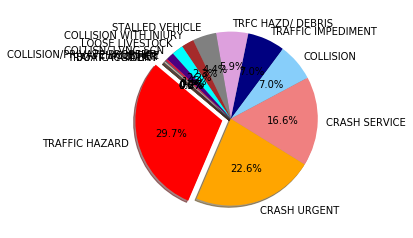

In [68]:
#type(x)
#print(x[0])
#print(x)
#print(x.index)
#type(x.index)
 
labels = df_from_csv_clean['Issue Reported'].value_counts().index
values = df_from_csv_clean['Issue Reported'].value_counts().values
colors = ["red", "orange", "lightcoral", "lightskyblue", "navy", "plum", "grey", "brown", "aqua", "indigo", "crimson", "dimgray", "silver", "orange", "lightcoral"]
explode = (0.1, 0, 0, 0, 0, 0, 0,0, 0, 0,0, 0, 0,0, 0, )
plt.axis("equal")
#plt.legend(labels=labels)

plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)




In [69]:
#look at use only may 16 data 018 data now
#keep only 2018 data
#row_condition = df_from_csv_clean["Published Date"] <= "2018-05-16 23:59:59"
#filtered_df = filtered_df.loc[row_condition]
#row_condition = filtered_df["Published Date"] >= "2018-05-16 00:00:01"
#filtered_df = filtered_df.loc[row_condition]
#filtered_df
#len(filtered_df)




In [70]:
#df_from_csv_clean = filtered_df

# code to take the lat and long and make a list for gmap

aus_lat = df_from_csv_clean["Latitude"]    #series
aus_long = df_from_csv_clean["Longitude"]    #series

aus_lat_subset = aus_lat.head(1000)   #make a subset to test
aus_long_subset = aus_long.head(1000)  # make a subset to test

#print(type(aus_lat_subset))     #its a series
#print(aus_lat_subset[0])        #whats the value?
#print(type(aus_lat_subset[0]))    #its a string

#print(aus_lat_subset)   #show the whole lat subset

#using zip function to zip the lat and long together to a list with each element being a tuple
aus_lat_long_list_subset = list(zip(aus_lat_subset, aus_long_subset))
aus_lat_long_list = list(zip(aus_lat, aus_long))

#print(aus_lat_long_list_subset)
#type(aus_lat_long_list_subset[0])    #each element is a tuple...yay!

In [71]:
# Customize the size of the figure      was   400 x 300
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [72]:
# Assign the marker layer to a variable  ..      DOING THE SUBSET HERE... TAKES ABOUT 10sec  

#help(gmaps.marker_layer)

markers = gmaps.marker_layer(aus_lat_long_list_subset)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…


# Define df's for team member's plotting use

### CREATING analysis_df AS FULL ACCIDENT DATAFRAME

In [73]:
#we will subdivide into these Issues Reported:
#Crash Urgent, Crash Service, COLLISION, COLLISION WITH INJURY, COLLISN/ LVNG SCN, COLLISION/PRIVATE PROPERTY, TRAFFIC FATALITY
analysis_issues = ('CRASH URGENT', 'CRASH SERVICE', 'COLLISION', 'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN', 'COLLISION/PRIVATE PROPERTY', 'TRAFFIC FATALITY')
analysis_df = filtered_df[filtered_df['Issue Reported'].isin(analysis_issues)]
# analysis_df.tail()
len(analysis_df)
#old was  34131...b4 Eric upper cases stuff

34381

### USING TIME MASKS TO CREATE rush_hr_df and no_rush_df FOR CONGESTION COMPARISONS

In [74]:
am_time_mask = (analysis_df['Published Date'].dt.hour >= 0) & \
           (analysis_df['Published Date'].dt.hour <= 5)
am_report_df = analysis_df[am_time_mask]
# am_report_df.head()

In [75]:
mid_time_mask = (analysis_df['Published Date'].dt.hour >= 9) & \
           (analysis_df['Published Date'].dt.hour <= 15)
mid_report_df = analysis_df[mid_time_mask]
# mid_report_df.head()

In [76]:
pm_time_mask = (analysis_df['Published Date'].dt.hour >= 19) & \
           (analysis_df['Published Date'].dt.hour <= 24)
pm_report_df = analysis_df[pm_time_mask]
# pm_report_df.head()

In [77]:
non_rush_1_df = am_report_df.append(mid_report_df, ignore_index=True)
# non_rush_1_df.head()

In [78]:
non_rush_df = non_rush_1_df.append(pm_report_df, ignore_index=True)
non_rush_df.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,69E356FC5B897FF52301D1A4D870E2862A05C244_15324...,2018-07-24 05:40:48,COLLISION,"(30.094498,-97.761155)",30.094498,-97.761155,6700-7940 S SH 45 E WB,ARCHIVED,2018-07-24 06:45:02
1,B039469E10CC32B9EB6AAEE8AABB64A15836746F_15381...,2018-09-29 00:58:05,CRASH SERVICE,"(30.287391,-97.741586)",30.287391,-97.741586,2340 Guadalupe St,ARCHIVED,2018-09-29 01:40:03
2,A0A82EBDD4A855C999B56CE855A244A672DCAFFF_15381...,2018-09-29 00:54:38,CRASH SERVICE,"(30.225971,-97.804548)",30.225971,-97.804548,Jones Rd & West Wind Trl,ARCHIVED,2018-09-29 02:10:03
3,08D67B9F9F6E2794FD86FD4B7E70E8360CCDBEAD_15381...,2018-09-29 02:37:20,CRASH SERVICE,"(30.311435,-97.709675)",30.311435,-97.709675,5200-5226 N Ih 35 Svrd Sb,ARCHIVED,2018-09-29 03:10:02
4,1D533EC2E7D744E1AC9A2E874A5F269093234DF3_15382...,2018-09-30 05:04:56,CRASH URGENT,"(30.411702,-97.722008)",30.411702,-97.722008,Amherst Dr & Duval Rd,ARCHIVED,2018-09-30 06:05:02


In [79]:
non_rush_df.count()

Traffic Report ID    24853
Published Date       24853
Issue Reported       24853
Location             24853
Latitude             24853
Longitude            24853
Address              24853
Status               24853
Status Date          24853
dtype: int64

In [80]:
am_rush_mask = (analysis_df['Published Date'].dt.hour >= 6) & \
           (analysis_df['Published Date'].dt.hour <= 8)
am_rush_df = analysis_df[am_rush_mask]
# am_rush_df.head()



In [81]:
pm_rush_mask = (analysis_df['Published Date'].dt.hour >= 16) & \
           (analysis_df['Published Date'].dt.hour <= 18)
pm_rush_df = analysis_df[pm_rush_mask]
# pm_rush_df.head()

In [82]:
rush_hr_df = am_rush_df.append(pm_rush_df, ignore_index=True)
# rush_hr_df.tail()
#rush_hr_df.count()

# FILTER BY MONTH
### USE (mmm)_report_df for ALL ACCIDENTS in that month
### USE (mmm)_report2_df for NON-RUSH HOUR ACCIDENTS in that month
### USE (mmm)_report3_df for all RUSH HOUR ACCIDENTS in that month

In [83]:
# Filter analysis df and non-rush df by month for plotting
# Generate January report dataframes
jan_mask = (analysis_df['Published Date'].dt.month == 1)
jan_mask2 = (non_rush_df['Published Date'].dt.month == 1)
jan_mask3 = (rush_hr_df['Published Date'].dt.month == 1)
jan_report_df = analysis_df[jan_mask]
jan_report2_df = non_rush_df[jan_mask2]
jan_report3_df = rush_hr_df[jan_mask3]
jan_count = jan_report_df['Published Date'].count()
jan_count2 = jan_report2_df['Published Date'].count()
jan_count3 = jan_report3_df['Published Date'].count()
# jan_count3

In [84]:
# Generate February report dataframes
feb_mask = (analysis_df['Published Date'].dt.month == 2)
feb_mask2 = (non_rush_df['Published Date'].dt.month == 2)
feb_mask3 = (rush_hr_df['Published Date'].dt.month == 2)
feb_report_df = analysis_df[feb_mask]
feb_report2_df = non_rush_df[feb_mask2]
feb_report3_df = rush_hr_df[feb_mask3]
feb_count = feb_report_df['Published Date'].count()
feb_count2 = feb_report2_df['Published Date'].count()
feb_count3 = feb_report3_df['Published Date'].count()

In [85]:
# Generate March report dataframes
mar_mask = (analysis_df['Published Date'].dt.month == 3)
mar_mask2 = (non_rush_df['Published Date'].dt.month == 3)
mar_mask3 = (rush_hr_df['Published Date'].dt.month == 3)
mar_report_df = analysis_df[mar_mask]
mar_report2_df = non_rush_df[mar_mask2]
mar_report3_df = rush_hr_df[mar_mask3]
mar_count = mar_report_df['Published Date'].count()
mar_count2 = mar_report2_df['Published Date'].count()
mar_count3 = mar_report3_df['Published Date'].count()

In [86]:
# Generate April report dataframes
apr_mask = (analysis_df['Published Date'].dt.month == 4)
apr_mask2 = (non_rush_df['Published Date'].dt.month == 4)
apr_mask3 = (rush_hr_df['Published Date'].dt.month == 4)
apr_report_df = analysis_df[apr_mask]
apr_report2_df = non_rush_df[apr_mask2]
apr_report3_df = rush_hr_df[apr_mask3]
apr_count = apr_report_df['Published Date'].count()
apr_count2 = apr_report2_df['Published Date'].count()
apr_count3 = apr_report3_df['Published Date'].count()

In [87]:
# Generate May report dataframes
may_mask = (analysis_df['Published Date'].dt.month == 5)
may_mask2 = (non_rush_df['Published Date'].dt.month == 5)
may_mask3 = (rush_hr_df['Published Date'].dt.month == 5)
may_report_df = analysis_df[may_mask]
may_report2_df = non_rush_df[may_mask2]
may_report3_df = rush_hr_df[may_mask3]
may_count = may_report_df['Published Date'].count()
may_count2 = may_report2_df['Published Date'].count()
may_count3 = may_report3_df['Published Date'].count()

In [88]:
# Generate June report dataframes
jun_mask = (analysis_df['Published Date'].dt.month == 6)
jun_mask2 = (non_rush_df['Published Date'].dt.month == 6)
jun_mask3 = (rush_hr_df['Published Date'].dt.month == 6)
jun_report_df = analysis_df[jun_mask]
jun_report2_df = non_rush_df[jun_mask2]
jun_report3_df = rush_hr_df[jun_mask3]
jun_count = jun_report_df['Published Date'].count()
jun_count2 = jun_report2_df['Published Date'].count()
jun_count3 = jun_report3_df['Published Date'].count()

In [89]:
# Generate July report dataframes
jul_mask = (analysis_df['Published Date'].dt.month == 7)
jul_mask2 = (non_rush_df['Published Date'].dt.month == 7)
jul_mask3 = (rush_hr_df['Published Date'].dt.month == 7)
jul_report_df = analysis_df[jul_mask]
jul_report2_df = non_rush_df[jul_mask2]
jul_report3_df = rush_hr_df[jul_mask3]
jul_count = jul_report_df['Published Date'].count()
jul_count2 = jul_report2_df['Published Date'].count()
jul_count3 = jul_report3_df['Published Date'].count()

In [90]:
# Generate August report dataframes
aug_mask = (analysis_df['Published Date'].dt.month == 8)
aug_mask2 = (non_rush_df['Published Date'].dt.month == 8)
aug_mask3 = (rush_hr_df['Published Date'].dt.month == 8)
aug_report_df = analysis_df[aug_mask]
aug_report2_df = non_rush_df[aug_mask2]
aug_report3_df = rush_hr_df[aug_mask3]
aug_count = aug_report_df['Published Date'].count()
aug_count2 = aug_report2_df['Published Date'].count()
aug_count3 = aug_report3_df['Published Date'].count()

In [91]:
# Generate September report dataframes
sep_mask = (analysis_df['Published Date'].dt.month == 9)
sep_mask2 = (non_rush_df['Published Date'].dt.month == 9)
sep_mask3 = (rush_hr_df['Published Date'].dt.month == 9)
sep_report_df = analysis_df[sep_mask]
sep_report2_df = non_rush_df[sep_mask2]
sep_report3_df = rush_hr_df[sep_mask3]
sep_count = sep_report_df['Published Date'].count()
sep_count2 = sep_report2_df['Published Date'].count()
sep_count3 = sep_report3_df['Published Date'].count()

In [92]:
# Generate October report dataframes
oct_mask = (analysis_df['Published Date'].dt.month == 10)
oct_mask2 = (non_rush_df['Published Date'].dt.month == 10)
oct_mask3 = (rush_hr_df['Published Date'].dt.month == 10)
oct_report_df = analysis_df[oct_mask]
oct_report2_df = non_rush_df[oct_mask2]
oct_report3_df = rush_hr_df[oct_mask3]
oct_count = oct_report_df['Published Date'].count()
oct_count2 = oct_report2_df['Published Date'].count()
oct_count3 = oct_report3_df['Published Date'].count()

In [93]:
# Generate November report dataframes
nov_mask = (analysis_df['Published Date'].dt.month == 11)
nov_mask2 = (non_rush_df['Published Date'].dt.month == 11)
nov_mask3 = (rush_hr_df['Published Date'].dt.month == 11)
nov_report_df = analysis_df[nov_mask]
nov_report2_df = non_rush_df[nov_mask2]
nov_report3_df = rush_hr_df[nov_mask3]
nov_count = nov_report_df['Published Date'].count()
nov_count2 = nov_report2_df['Published Date'].count()
nov_count3 = nov_report3_df['Published Date'].count()

In [94]:
# Generate December report dataframes
dec_mask = (analysis_df['Published Date'].dt.month == 12)
dec_mask2 = (non_rush_df['Published Date'].dt.month == 12)
dec_mask3 = (rush_hr_df['Published Date'].dt.month == 12)
dec_report_df = analysis_df[dec_mask]
dec_report2_df = non_rush_df[dec_mask2]
dec_report3_df = rush_hr_df[dec_mask3]
dec_count = dec_report_df['Published Date'].count()
dec_count2 = dec_report2_df['Published Date'].count()
dec_count3 = dec_report3_df['Published Date'].count()
# dec_count2

In [95]:
# months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
# accidents = [
#     jan_count, feb_count, mar_count, apr_count, may_count, jun_count,
#     jul_count, aug_count, sep_count, oct_count, nov_count, dec_count
# ]

# x_axis = np.arange(len(months))

In [96]:
# # Create a bar chart based upon the above data
# plt.bar(x_axis, accidents, color="blue", alpha=0.75, align="center")
# # Create the ticks for our bar chart's x axis
# tick_locations = [value for value in x_axis]
# plt.xticks(tick_locations, (months))
# # Set the limits of the x axis
# plt.xlim(-0.75, len(x_axis)-0.25)
# # Set the limits of the y axis
# plt.ylim(0, max(accidents)+500)
# # Give the chart a title, x label, and y label
# plt.title("Accident Frequency by Month - 2018")
# plt.xlabel("Months")
# plt.ylabel("Number of Accidents")
# # Save an image of the chart and print it to the screen
# plt.savefig("output_data/MonthComparison.png")


# FILTER BY DAY OF THE WEEK
### USE (ddd)_all_df for ALL ACCIDENTS in that DAY of the WEEK¶
### USE (ddd)_norush_df for NON-RUSH HOUR ACCIDENTS in that DAY of the WEEK
### USE (ddd)_rushhr_df for all RUSH HOUR ACCIDENTS in that DAY of the WEEK

In [97]:
# Filter analysis df by day of week for plotting
# Generate Monday report dataframes
mon_all_mask = (analysis_df['Published Date'].dt.dayofweek == 0)
mon_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 0)
mon_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 0)
mon_all_df = analysis_df[mon_all_mask]
mon_norush_df = non_rush_df[mon_norush_mask]
mon_rushhr_df = rush_hr_df[mon_rushhr_mask]
mon_all_count = mon_all_df['Published Date'].count()
mon_norush_count = mon_norush_df['Published Date'].count()
mon_rushhr_count = mon_rushhr_df['Published Date'].count()
# mon_report_df.tail()
# mon_norush_count
# mon_rushhr_count

In [98]:
# Generate Tuesday report dataframes
tue_all_mask = (analysis_df['Published Date'].dt.dayofweek == 1)
tue_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 1)
tue_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 1)
tue_all_df = analysis_df[tue_all_mask]
tue_norush_df = non_rush_df[tue_norush_mask]
tue_rushhr_df = rush_hr_df[tue_rushhr_mask]
tue_all_count = tue_all_df['Published Date'].count()
tue_norush_count = tue_norush_df['Published Date'].count()
tue_rushhr_count = tue_rushhr_df['Published Date'].count()

# tue_report_df.tail()
# tue_rushhr_count

In [99]:
# Generate Wednesday report dataframes
wed_all_mask = (analysis_df['Published Date'].dt.dayofweek == 2)
wed_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 2)
wed_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 2)
wed_all_df = analysis_df[wed_all_mask]
wed_norush_df = non_rush_df[wed_norush_mask]
wed_rushhr_df = rush_hr_df[wed_rushhr_mask]
wed_all_count = wed_all_df['Published Date'].count()
wed_norush_count = wed_norush_df['Published Date'].count()
wed_rushhr_count = wed_rushhr_df['Published Date'].count()

# wed_report_df.tail()
# wed_rushhr_count

In [100]:
# Generate Thursday report dataframes
thu_all_mask = (analysis_df['Published Date'].dt.dayofweek == 3)
thu_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 3)
thu_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 3)
thu_all_df = analysis_df[thu_all_mask]
thu_norush_df = non_rush_df[thu_norush_mask]
thu_rushhr_df = rush_hr_df[thu_rushhr_mask]
thu_all_count = thu_all_df['Published Date'].count()
thu_norush_count = thu_norush_df['Published Date'].count()
thu_rushhr_count = thu_rushhr_df['Published Date'].count()

# thu_report_df.tail()
# thu_rushhr_count

In [101]:
# Generate Friday report dataframes
fri_all_mask = (analysis_df['Published Date'].dt.dayofweek == 4)
fri_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 4)
fri_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 4)
fri_all_df = analysis_df[fri_all_mask]
fri_norush_df = non_rush_df[fri_norush_mask]
fri_rushhr_df = rush_hr_df[fri_rushhr_mask]
fri_all_count = fri_all_df['Published Date'].count()
fri_norush_count = fri_norush_df['Published Date'].count()
fri_rushhr_count = fri_rushhr_df['Published Date'].count()


# fri_report_df.tail()
# fri_rushhr_count

In [102]:
# Generate Saturday report dataframes
sat_all_mask = (analysis_df['Published Date'].dt.dayofweek == 5)
sat_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 5)
sat_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 5)
sat_all_df = analysis_df[sat_all_mask]
sat_norush_df = non_rush_df[sat_norush_mask]
sat_rushhr_df = rush_hr_df[sat_rushhr_mask]
sat_all_count = sat_all_df['Published Date'].count()
sat_norush_count = sat_norush_df['Published Date'].count()
sat_rushhr_count = sat_rushhr_df['Published Date'].count()

# sat_report_df.tail()
# sat_rushhr_count

In [103]:
# Generate Sunday report dataframes
sun_all_mask = (analysis_df['Published Date'].dt.dayofweek == 6)
sun_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 6)
sun_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 6)
sun_all_df = analysis_df[sun_all_mask]
sun_norush_df = non_rush_df[sun_norush_mask]
sun_rushhr_df = rush_hr_df[sun_rushhr_mask]
sun_all_count = sun_all_df['Published Date'].count()
sun_norush_count = sun_norush_df['Published Date'].count()
sun_rushhr_count = sun_rushhr_df['Published Date'].count()

# sun_report_df.tail()
# sun_rushhr_count

# FILTER BY HOUR
### USE hr_(##)_all_df for ALL ACCIDENTS in that HOUR of the DAY¶

In [104]:
# Filter analysis dataframe by time of the day for plotting
# Generate Midnight to 1am report dataframes
hr_00_mask = (analysis_df['Published Date'].dt.hour == 0)
hr_00_all_df = analysis_df[hr_00_mask]
hr_00_all_count = hr_00_all_df['Published Date'].count()
# hr_00_all_count

In [105]:
# Generate 1am to 2am report dataframes
hr_01_mask = (analysis_df['Published Date'].dt.hour == 1)
hr_01_all_df = analysis_df[hr_01_mask]
hr_01_all_count = hr_01_all_df['Published Date'].count()
# hr_01_all_count

In [106]:
# Generate 2am to 3am report dataframes
hr_02_mask = (analysis_df['Published Date'].dt.hour == 2)
hr_02_all_df = analysis_df[hr_02_mask]
hr_02_all_count = hr_02_all_df['Published Date'].count()
# hr_02_all_count

In [107]:
# Generate 3am to 4am report dataframes
hr_03_mask = (analysis_df['Published Date'].dt.hour == 3)
hr_03_all_df = analysis_df[hr_03_mask]
hr_03_all_count = hr_03_all_df['Published Date'].count()
# hr_03_all_count

In [108]:
# Generate 4am to 5am report dataframes
hr_04_mask = (analysis_df['Published Date'].dt.hour == 4)
hr_04_all_df = analysis_df[hr_04_mask]
hr_04_all_count = hr_04_all_df['Published Date'].count()
# hr_04_all_count

In [109]:
# Generate 5am to 6am report dataframes
hr_05_mask = (analysis_df['Published Date'].dt.hour == 5)
hr_05_all_df = analysis_df[hr_05_mask]
hr_05_all_count = hr_05_all_df['Published Date'].count()
# hr_05_all_count

In [110]:
# Generate 6am to 7am report dataframes
hr_06_mask = (analysis_df['Published Date'].dt.hour == 6)
hr_06_all_df = analysis_df[hr_06_mask]
hr_06_all_count = hr_06_all_df['Published Date'].count()
# hr_06_all_count

In [111]:
# Generate 7am to 8am report dataframes
hr_07_mask = (analysis_df['Published Date'].dt.hour == 7)
hr_07_all_df = analysis_df[hr_07_mask]
hr_07_all_count = hr_07_all_df['Published Date'].count()
# hr_07_all_count

In [112]:
# Generate 8am to 9am report dataframes
hr_08_mask = (analysis_df['Published Date'].dt.hour == 8)
hr_08_all_df = analysis_df[hr_08_mask]
hr_08_all_count = hr_08_all_df['Published Date'].count()
# hr_08_all_count

In [113]:
# Generate 9am to 10am report dataframes
hr_09_mask = (analysis_df['Published Date'].dt.hour == 9)
hr_09_all_df = analysis_df[hr_09_mask]
hr_09_all_count = hr_09_all_df['Published Date'].count()
# hr_09_all_count

In [114]:
# Generate 10am to 11am report dataframes
hr_10_mask = (analysis_df['Published Date'].dt.hour == 10)
hr_10_all_df = analysis_df[hr_10_mask]
hr_10_all_count = hr_10_all_df['Published Date'].count()
# hr_10_all_count

In [115]:
# Generate 11am to Noon report dataframes
hr_11_mask = (analysis_df['Published Date'].dt.hour == 11)
hr_11_all_df = analysis_df[hr_11_mask]
hr_11_all_count = hr_11_all_df['Published Date'].count()
# hr_11_all_count

In [116]:
# Generate Noon to 1pm report dataframes
hr_12_mask = (analysis_df['Published Date'].dt.hour == 12)
hr_12_all_df = analysis_df[hr_12_mask]
hr_12_all_count = hr_12_all_df['Published Date'].count()
# hr_12_all_count

In [117]:
# Generate 1pm to 2pm report dataframes
hr_13_mask = (analysis_df['Published Date'].dt.hour == 13)
hr_13_all_df = analysis_df[hr_13_mask]
hr_13_all_count = hr_13_all_df['Published Date'].count()
# hr_13_all_count

In [118]:
# Generate 2pm to 3pm report dataframes
hr_14_mask = (analysis_df['Published Date'].dt.hour == 14)
hr_14_all_df = analysis_df[hr_14_mask]
hr_14_all_count = hr_14_all_df['Published Date'].count()
# hr_14_all_count

In [119]:
# Generate 3pm to 4pm report dataframes
hr_15_mask = (analysis_df['Published Date'].dt.hour == 15)
hr_15_all_df = analysis_df[hr_15_mask]
hr_15_all_count = hr_15_all_df['Published Date'].count()
# hr_15_all_count

In [120]:
# Generate 4pm to 5pm report dataframes
hr_16_mask = (analysis_df['Published Date'].dt.hour == 16)
hr_16_all_df = analysis_df[hr_16_mask]
hr_16_all_count = hr_16_all_df['Published Date'].count()
# hr_16_all_count

In [121]:
# Generate 5pm to 6pm report dataframes
hr_17_mask = (analysis_df['Published Date'].dt.hour == 17)
hr_17_all_df = analysis_df[hr_17_mask]
hr_17_all_count = hr_17_all_df['Published Date'].count()
# hr_17_all_count

In [122]:
# Generate 6pm to 7pm report dataframes
hr_18_mask = (analysis_df['Published Date'].dt.hour == 18)
hr_18_all_df = analysis_df[hr_18_mask]
hr_18_all_count = hr_18_all_df['Published Date'].count()
# hr_18_all_count

In [123]:
# Generate 7pm to 8pm report dataframes
hr_19_mask = (analysis_df['Published Date'].dt.hour == 19)
hr_19_all_df = analysis_df[hr_19_mask]
hr_19_all_count = hr_19_all_df['Published Date'].count()
# hr_19_all_count

In [124]:
# Generate 8pm to 9pm report dataframes
hr_20_mask = (analysis_df['Published Date'].dt.hour == 20)
hr_20_all_df = analysis_df[hr_20_mask]
hr_20_all_count = hr_20_all_df['Published Date'].count()
# hr_20_all_count

In [125]:
# Generate 9pm to 10pm report dataframes
hr_21_mask = (analysis_df['Published Date'].dt.hour == 21)
hr_21_all_df = analysis_df[hr_21_mask]
hr_21_all_count = hr_21_all_df['Published Date'].count()
# hr_21_all_count

In [126]:
# Generate 10pm to 11pm report dataframes
hr_22_mask = (analysis_df['Published Date'].dt.hour == 22)
hr_22_all_df = analysis_df[hr_22_mask]
hr_22_all_count = hr_22_all_df['Published Date'].count()
# hr_22_all_count

In [127]:
# Generate 11pm to Midnight report dataframes
hr_23_mask = (analysis_df['Published Date'].dt.hour == 23)
hr_23_all_df = analysis_df[hr_23_mask]
hr_23_all_count = hr_23_all_df['Published Date'].count()
# hr_23_all_count

# PLOTS FOR ANALYSIS

### Using Plotly for analysis

In [128]:
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

## Accident Totals by Day of the Week - 2018

In [129]:
trace1 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[
    mon_rushhr_count, tue_rushhr_count, wed_rushhr_count, thu_rushhr_count, fri_rushhr_count, sat_rushhr_count, sun_rushhr_count
],
    name='Rush Hour Accidents'
)
trace2 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[
    mon_norush_count, tue_norush_count, wed_norush_count, thu_norush_count, fri_norush_count, sat_norush_count, sun_norush_count
],
    name='Non-rush Hour Accidents'
)

In [130]:
data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accident Totals by Hour of the Day - all days in 2018

In [131]:
trace3 = go.Bar(
    x=[
    "0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100",
    "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"
      ],
    y=[
    hr_00_all_count, hr_01_all_count, hr_02_all_count, hr_03_all_count, hr_04_all_count, hr_05_all_count,
    hr_06_all_count, hr_07_all_count, hr_08_all_count, hr_09_all_count, hr_10_all_count, hr_11_all_count,
    hr_12_all_count, hr_13_all_count, hr_14_all_count, hr_15_all_count, hr_16_all_count, hr_17_all_count,
    hr_18_all_count, hr_19_all_count, hr_20_all_count, hr_21_all_count, hr_22_all_count, hr_23_all_count,        
],
    name='Accidents by Hour'
)

In [132]:
data = [trace3]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accident Totals by Hour of the Day - Fridays in 2018

In [133]:
# Filter by Hour and Day - Friday
hr_00_Fri_df = hr_00_all_df[fri_all_mask]
hr_00_Fri_df_count = hr_00_Fri_df['Published Date'].count()
hr_01_Fri_df = hr_01_all_df[fri_all_mask]
hr_01_Fri_df_count = hr_01_Fri_df['Published Date'].count()
hr_02_Fri_df = hr_02_all_df[fri_all_mask]
hr_02_Fri_df_count = hr_02_Fri_df['Published Date'].count()
hr_03_Fri_df = hr_03_all_df[fri_all_mask]
hr_03_Fri_df_count = hr_03_Fri_df['Published Date'].count()
hr_04_Fri_df = hr_04_all_df[fri_all_mask]
hr_04_Fri_df_count = hr_04_Fri_df['Published Date'].count()
hr_05_Fri_df = hr_05_all_df[fri_all_mask]
hr_05_Fri_df_count = hr_05_Fri_df['Published Date'].count()
hr_06_Fri_df = hr_06_all_df[fri_all_mask]
hr_06_Fri_df_count = hr_06_Fri_df['Published Date'].count()
hr_07_Fri_df = hr_07_all_df[fri_all_mask]
hr_07_Fri_df_count = hr_07_Fri_df['Published Date'].count()
hr_08_Fri_df = hr_08_all_df[fri_all_mask]
hr_08_Fri_df_count = hr_08_Fri_df['Published Date'].count()
hr_09_Fri_df = hr_09_all_df[fri_all_mask]
hr_09_Fri_df_count = hr_09_Fri_df['Published Date'].count()
hr_10_Fri_df = hr_10_all_df[fri_all_mask]
hr_10_Fri_df_count = hr_10_Fri_df['Published Date'].count()
hr_11_Fri_df = hr_11_all_df[fri_all_mask]
hr_11_Fri_df_count = hr_11_Fri_df['Published Date'].count()
hr_12_Fri_df = hr_12_all_df[fri_all_mask]
hr_12_Fri_df_count = hr_12_Fri_df['Published Date'].count()
hr_13_Fri_df = hr_13_all_df[fri_all_mask]
hr_13_Fri_df_count = hr_13_Fri_df['Published Date'].count()
hr_14_Fri_df = hr_14_all_df[fri_all_mask]
hr_14_Fri_df_count = hr_14_Fri_df['Published Date'].count()
hr_15_Fri_df = hr_15_all_df[fri_all_mask]
hr_15_Fri_df_count = hr_15_Fri_df['Published Date'].count()
hr_15_Fri_df = hr_15_all_df[fri_all_mask]
hr_15_Fri_df_count = hr_15_Fri_df['Published Date'].count()
hr_16_Fri_df = hr_16_all_df[fri_all_mask]
hr_16_Fri_df_count = hr_16_Fri_df['Published Date'].count()
hr_17_Fri_df = hr_17_all_df[fri_all_mask]
hr_17_Fri_df_count = hr_17_Fri_df['Published Date'].count()
hr_18_Fri_df = hr_18_all_df[fri_all_mask]
hr_18_Fri_df_count = hr_18_Fri_df['Published Date'].count()
hr_19_Fri_df = hr_19_all_df[fri_all_mask]
hr_19_Fri_df_count = hr_19_Fri_df['Published Date'].count()
hr_20_Fri_df = hr_20_all_df[fri_all_mask]
hr_20_Fri_df_count = hr_20_Fri_df['Published Date'].count()
hr_21_Fri_df = hr_21_all_df[fri_all_mask]
hr_21_Fri_df_count = hr_21_Fri_df['Published Date'].count()
hr_22_Fri_df = hr_22_all_df[fri_all_mask]
hr_22_Fri_df_count = hr_22_Fri_df['Published Date'].count()
hr_23_Fri_df = hr_23_all_df[fri_all_mask]
hr_23_Fri_df_count = hr_23_Fri_df['Published Date'].count()

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anacon

In [134]:
trace6 = go.Bar(
    x=[
    "0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100",
    "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"
      ],
    y=[
    hr_00_Fri_df_count, hr_01_Fri_df_count, hr_02_Fri_df_count, hr_03_Fri_df_count, hr_04_Fri_df_count, hr_05_Fri_df_count,
    hr_06_Fri_df_count, hr_07_Fri_df_count, hr_08_Fri_df_count, hr_09_Fri_df_count, hr_10_Fri_df_count, hr_11_Fri_df_count,
    hr_12_Fri_df_count, hr_13_Fri_df_count, hr_14_Fri_df_count, hr_15_Fri_df_count, hr_16_Fri_df_count, hr_17_Fri_df_count,
    hr_18_Fri_df_count, hr_19_Fri_df_count, hr_20_Fri_df_count, hr_21_Fri_df_count, hr_22_Fri_df_count, hr_23_Fri_df_count,        
],
    name='Accidents by Hour on Friday'
)

In [135]:
data = [trace6]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accident Totals by Month - 2018

In [136]:
trace1 = go.Bar(
    x=["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"],
    y=[
    jan_count3, feb_count3, mar_count3, apr_count3, may_count3, jun_count3,
    jul_count3, aug_count3, sep_count3, oct_count3, nov_count3, dec_count3
],
    name='Rush Hour Accidents'
)
trace2 = go.Bar(
    x=["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"],
    y=[
    jan_count2, feb_count2, mar_count2, apr_count2, may_count2, jun_count2,
    jul_count2, aug_count2, sep_count2, oct_count2, nov_count2, dec_count2
],
    name='Non-rush Hour Accidents'
)

In [137]:
data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Take a closer look at May and October
## Accidents by Day of the Week - May 2018

In [138]:
may_mon_df = (mon_all_df['Published Date'].dt.month == 5)
may_tue_df = (tue_all_df['Published Date'].dt.month == 5)
may_wed_df = (wed_all_df['Published Date'].dt.month == 5)
may_thu_df = (thu_all_df['Published Date'].dt.month == 5)
may_fri_df = (fri_all_df['Published Date'].dt.month == 5)
may_sat_df = (sat_all_df['Published Date'].dt.month == 5)
may_sun_df = (sun_all_df['Published Date'].dt.month == 5)
may_mon_count = may_mon_df.count()
may_tue_count = may_tue_df.count()
may_wed_count = may_wed_df.count()
may_thu_count = may_thu_df.count()
may_fri_count = may_fri_df.count()
may_sat_count = may_sat_df.count()
may_sun_count = may_sun_df.count()
# may_mon_df.count()

In [139]:
trace8 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[may_mon_count, may_tue_count, may_wed_count, may_thu_count, may_fri_count, may_sat_count, may_sun_count],
    name='Accidents by Day in May'
)

In [140]:
data = [trace8]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accidents by Date - May 2018

In [141]:
may_daily_count = may_report_df.groupby(by=may_report_df['Published Date'].dt.date).count()
may_accident_days = may_daily_count['Issue Reported']
# may_accident_days.values

In [142]:
may_accident_days.index

may_index = may_accident_days.index
# may_index

In [143]:
trace10 = go.Scatter(
    x=may_accident_days.index,
    y=may_accident_days.values,
    name='Accidents by Date in May'
)

In [144]:
data = [trace10]
layout = go.Layout()

fig = go.Figure(data=data)
py.offline.iplot(fig)

In [145]:
trace9 = go.Bar(
    x=may_accident_days.index,
    y=may_accident_days.values,
    name='Accidents by Date in May'
)

In [146]:
data = [trace9]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Taking a Closer Look at Wednesday May 16, 2018

In [147]:
may_mask = (analysis_df['Published Date'].dt.month == 5)

hr_00_Fri_df = hr_00_all_df[fri_all_mask]
hr_00_Fri_df_count = hr_00_Fri_df['Published Date'].count()

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [148]:
# Filter by Hour and Day - Wednesday, May 16
hr_00_Wed_df = hr_00_all_df[wed_all_mask]
hr_00_Wed_16_df = hr_00_Wed_df['Published Date'].dt.day == 16
hr_00_Wed_16_df_count = hr_00_Wed_16_df.count()
hr_01_Wed_df = hr_01_all_df[wed_all_mask]
hr_01_Wed_16_df = hr_01_Wed_df['Published Date'].dt.day == 16
hr_01_Wed_16_df_count = hr_01_Wed_16_df.count()
hr_02_Wed_df = hr_02_all_df[wed_all_mask]
hr_02_Wed_16_df = hr_02_Wed_df['Published Date'].dt.day == 16
hr_02_Wed_16_df_count = hr_02_Wed_16_df.count()
hr_03_Wed_df = hr_03_all_df[wed_all_mask]
hr_03_Wed_16_df = hr_03_Wed_df['Published Date'].dt.day == 16
hr_03_Wed_16_df_count = hr_03_Wed_16_df.count()
hr_04_Wed_df = hr_04_all_df[wed_all_mask]
hr_04_Wed_16_df = hr_04_Wed_df['Published Date'].dt.day == 16
hr_04_Wed_16_df_count = hr_04_Wed_16_df.count()
hr_05_Wed_df = hr_05_all_df[wed_all_mask]
hr_05_Wed_16_df = hr_05_Wed_df['Published Date'].dt.day == 16
hr_05_Wed_16_df_count = hr_05_Wed_16_df.count()
hr_06_Wed_df = hr_06_all_df[wed_all_mask]
hr_06_Wed_16_df = hr_06_Wed_df['Published Date'].dt.day == 16
hr_06_Wed_16_df_count = hr_06_Wed_16_df.count()
hr_07_Wed_df = hr_07_all_df[wed_all_mask]
hr_07_Wed_16_df = hr_07_Wed_df['Published Date'].dt.day == 16
hr_07_Wed_16_df_count = hr_07_Wed_16_df.count()
hr_08_Wed_df = hr_08_all_df[wed_all_mask]
hr_08_Wed_16_df = hr_08_Wed_df['Published Date'].dt.day == 16
hr_08_Wed_16_df_count = hr_08_Wed_16_df.count()
hr_09_Wed_df = hr_09_all_df[wed_all_mask]
hr_09_Wed_16_df = hr_09_Wed_df['Published Date'].dt.day == 16
hr_09_Wed_16_df_count = hr_09_Wed_16_df.count()
hr_10_Wed_df = hr_10_all_df[wed_all_mask]
hr_10_Wed_16_df = hr_10_Wed_df['Published Date'].dt.day == 16
hr_10_Wed_16_df_count = hr_10_Wed_16_df.count()
hr_11_Wed_df = hr_11_all_df[wed_all_mask]
hr_11_Wed_16_df = hr_11_Wed_df['Published Date'].dt.day == 16
hr_11_Wed_16_df_count = hr_11_Wed_16_df.count()
hr_12_Wed_df = hr_12_all_df[wed_all_mask]
hr_12_Wed_16_df = hr_12_Wed_df['Published Date'].dt.day == 16
hr_12_Wed_16_df_count = hr_12_Wed_16_df.count()
hr_13_Wed_df = hr_13_all_df[wed_all_mask]
hr_13_Wed_16_df = hr_13_Wed_df['Published Date'].dt.day == 16
hr_13_Wed_16_df_count = hr_13_Wed_16_df.count()
hr_14_Wed_df = hr_14_all_df[wed_all_mask]
hr_14_Wed_16_df = hr_14_Wed_df['Published Date'].dt.day == 16
hr_14_Wed_16_df_count = hr_14_Wed_16_df.count()
hr_15_Wed_df = hr_15_all_df[wed_all_mask]
hr_15_Wed_16_df = hr_15_Wed_df['Published Date'].dt.day == 16
hr_15_Wed_16_df_count = hr_15_Wed_16_df.count()
hr_16_Wed_df = hr_16_all_df[wed_all_mask]
hr_16_Wed_16_df = hr_16_Wed_df['Published Date'].dt.day == 16
hr_16_Wed_16_df_count = hr_16_Wed_16_df.count()
hr_17_Wed_df = hr_17_all_df[wed_all_mask]
hr_17_Wed_16_df = hr_17_Wed_df['Published Date'].dt.day == 16
hr_17_Wed_16_df_count = hr_17_Wed_16_df.count()
hr_18_Wed_df = hr_18_all_df[wed_all_mask]
hr_18_Wed_16_df = hr_18_Wed_df['Published Date'].dt.day == 16
hr_18_Wed_16_df_count = hr_18_Wed_16_df.count()
hr_19_Wed_df = hr_19_all_df[wed_all_mask]
hr_19_Wed_16_df = hr_19_Wed_df['Published Date'].dt.day == 16
hr_19_Wed_16_df_count = hr_19_Wed_16_df.count()
hr_20_Wed_df = hr_20_all_df[wed_all_mask]
hr_20_Wed_16_df = hr_20_Wed_df['Published Date'].dt.day == 16
hr_20_Wed_16_df_count = hr_20_Wed_16_df.count()
hr_21_Wed_df = hr_21_all_df[wed_all_mask]
hr_21_Wed_16_df = hr_21_Wed_df['Published Date'].dt.day == 16
hr_21_Wed_16_df_count = hr_21_Wed_16_df.count()
hr_22_Wed_df = hr_22_all_df[wed_all_mask]
hr_22_Wed_16_df = hr_22_Wed_df['Published Date'].dt.day == 16
hr_22_Wed_16_df_count = hr_22_Wed_16_df.count()
hr_23_Wed_df = hr_23_all_df[wed_all_mask]
hr_23_Wed_16_df = hr_23_Wed_df['Published Date'].dt.day == 16
hr_23_Wed_16_df_count = hr_23_Wed_16_df.count()

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\rstaveley\AppData\Local\Continuum\anaco

In [149]:
trace10 = go.Bar(
    x=[
    "0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100",
    "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"
      ],
    y=[
    hr_00_Wed_16_df_count, hr_01_Wed_16_df_count, hr_02_Wed_16_df_count, hr_03_Wed_16_df_count, hr_04_Wed_16_df_count, hr_05_Wed_16_df_count,
    hr_06_Wed_16_df_count, hr_07_Wed_16_df_count, hr_08_Wed_16_df_count, hr_09_Wed_16_df_count, hr_10_Wed_16_df_count, hr_11_Wed_16_df_count,
    hr_12_Wed_16_df_count, hr_13_Wed_16_df_count, hr_14_Wed_16_df_count, hr_15_Wed_16_df_count, hr_16_Wed_16_df_count, hr_17_Wed_16_df_count,
    hr_18_Wed_16_df_count, hr_19_Wed_16_df_count, hr_20_Wed_16_df_count, hr_21_Wed_16_df_count, hr_22_Wed_16_df_count, hr_23_Wed_16_df_count,        
],
    name='Accidents by Hour on May 16, 2018'
)

In [150]:
data = [trace10]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accidents by Day of the Week - October 2018

In [151]:
oct_mon_df = (mon_all_df['Published Date'].dt.month == 10)
oct_tue_df = (tue_all_df['Published Date'].dt.month == 10)
oct_wed_df = (wed_all_df['Published Date'].dt.month == 10)
oct_thu_df = (thu_all_df['Published Date'].dt.month == 10)
oct_fri_df = (fri_all_df['Published Date'].dt.month == 10)
oct_sat_df = (sat_all_df['Published Date'].dt.month == 10)
oct_sun_df = (sun_all_df['Published Date'].dt.month == 10)
oct_mon_count = oct_mon_df.count()
oct_tue_count = oct_tue_df.count()
oct_wed_count = oct_wed_df.count()
oct_thu_count = oct_thu_df.count()
oct_fri_count = oct_fri_df.count()
oct_sat_count = oct_sat_df.count()
oct_sun_count = oct_sun_df.count()
# oct_mon_df.count()

In [152]:
trace7 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[oct_mon_count, oct_tue_count, oct_wed_count, oct_thu_count, oct_fri_count, oct_sat_count, oct_sun_count],
    name='Accidents by Day in October'
)

In [153]:
data = [trace7]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [154]:
# code to take the lat and long and make a list for gmap

aus_lat = df_from_csv_clean["Latitude"]    #series
aus_long = df_from_csv_clean["Longitude"]    #series

aus_lat_subset = aus_lat.head(1000)   #make a subset to test
aus_long_subset = aus_long.head(1000)  # make a subset to test

#print(type(aus_lat_subset))     #its a series
#print(aus_lat_subset[0])        #whats the value?
#print(type(aus_lat_subset[0]))    #its a string

#print(aus_lat_subset)   #show the whole lat subset

#using zip function to zip the lat and long together to a list with each element being a tuple
aus_lat_long_list_subset = list(zip(aus_lat_subset, aus_long_subset))
aus_lat_long_list = list(zip(aus_lat, aus_long))

#print(aus_lat_long_list_subset)
#type(aus_lat_long_list_subset[0])    #each element is a tuple...yay!

In [155]:
# Customize the size of the figure      was   400 x 300
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [156]:
# Assign the marker layer to a variable  ..      DOING THE SUBSET HERE... TAKES ABOUT 10sec  

#help(gmaps.marker_layer)

markers = gmaps.marker_layer(aus_lat_long_list_subset)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

In [157]:
#help(gmaps.marker_layer)
#extracting the marker image is a bit different than plt.savefig....basically
#gmaps only lets you save the .html  OR  you can manually dload the fig 
#within the display frame
#per https://jupyter-gmaps.readthedocs.io/en/latest/export.html
#
#to export:
#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('exported_filename_here.html', views=[fig])
#
#to open the file:
#python -m http.server 8080
#Navigate to http://0.0.0.0:8080/exported_filename.html and you should see the export!


In [158]:
fig = gmaps.figure(map_type='HYBRID')
heatmap_layer = gmaps.heatmap_layer(aus_lat_long_list_subset)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [159]:
#saving the marker image is a bit different than plt.savefig....basically
#gmaps only lets you save the .html  OR  you can manually dload the fig 
#within the display frame
#per https://jupyter-gmaps.readthedocs.io/en/latest/export.html
#
#to export:
#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('exported_filename_here.html', views=[fig])
#
#to open the file:
#python -m http.server 8080
#Navigate to http://0.0.0.0:8080/exported_filename.html and you should see the export!